In [ ]:
import os
import numpy as np
from pylab import show, figure, plot
import time
from landlab import RasterModelGrid
from landlab.plot.imshow import imshow_grid
from landlab.io import read_esri_ascii
import matplotlib.pyplot as plt
from osgeo import gdal
import glob
from PIL import Image
import matplotlib.cbook as cbook
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import LightSource
from landlab.io.obj import write_obj
from landlab.components import LinearDiffuser,DepthDependentDiffuser,TaylorNonLinearDiffuser,DepthDependentTaylorDiffuser
from landlab.io import write_esri_ascii

### A set of scripts to simulate landscape evolution of a scarp over a desired timescale

### User defined options

In [2]:
DEM_name = "DEMs/R1.asc"  # set name of your DEM here
total_time = 1000  # set total time of simulation in years here, code will output diffused scarp over that timescale
# if eroded_DEMs folder does not exist, create it
if not os.path.exists("eroded_DEMs"):
    os.makedirs("eroded_DEMs")

name = DEM_name.split("/")[-1].split(".")[0]
file_name_export = (
    f"eroded_DEMs/{name}_linear_{total_time}.asc"  # set name of output synthetic DEM here
)

### load DEM 

/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:412: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["node"]
/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:535: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  return self.ds.dims["link"]
/opt/homebrew/anaconda3/envs/scarp_erosion/lib/python3.12/site-packages/landlab/graph/graph.py:984: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `

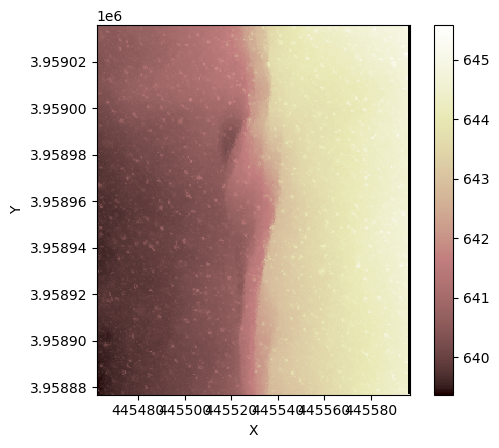

In [3]:
# load DEM -- uses some landlab commands
mg, z = read_esri_ascii(DEM_name, name="topographic__elevation")
np.all(mg.at_node["topographic__elevation"] == z)
mg.set_fixed_value_boundaries_at_grid_edges(False, True, False, True)
mg.set_closed_boundaries_at_grid_edges(True, False, True, False)
hillshade = mg.calc_hillshade_at_node(elevs=z, alt=30.0, az=100.0)
imshow_grid(mg, z)  # plot_type, 'Hillshade'
slope_t0 = mg.calc_slope_at_node(z)
z_t0 = z[mg.nodes]

### Define 2D diffusion set-up

We define our transport rate and 2D diffusion set-up (using linear diffusion)

In [4]:
D = 0.001  # m2/yr transport coefficient (0.001 m2/yr for Basin and Range)
dt = 0.2 * mg.dx * mg.dx / D  # set time step to 50 yrs
mg.set_closed_boundaries_at_grid_edges(True, True, True, True)
len(mg.core_nodes)
qs = mg.add_zeros("sediment_flux", at="link")

if total_time < dt:
    ValueError("The total time is smaller than the time-step!!")

### Simulate diffusion

In [5]:
n_iter = int(total_time / dt)

for p in range(n_iter):
    g = mg.calc_grad_at_link(z)
    qs[mg.active_links] = -D * g[mg.active_links]
    dzdt = -mg.calc_flux_div_at_node(qs)
    z[mg.core_nodes] += dzdt[mg.core_nodes] * dt

Text(0.5, 1.0, 'R1, 1000 years')

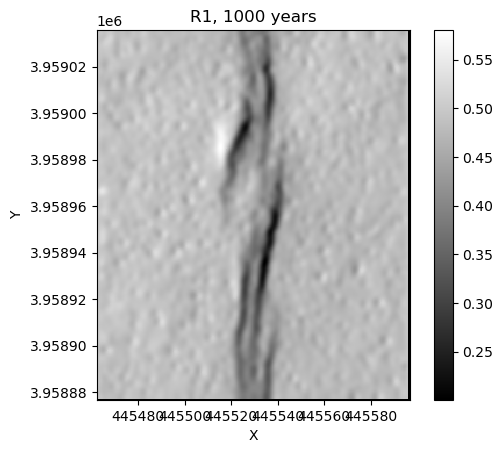

In [10]:
# option to visualize and double check
hillshade = mg.calc_hillshade_at_node(elevs=z, alt=30.0, az=100.0)
imshow_grid(mg, hillshade, cmap="gray")
plt.title(f"{name}, {total_time} years" )  

### Export synthetic DEM after diffusion

as an ascii file

In [ ]:
write_esri_ascii(file_name_export, mg)

['eroded_DEMs/R1_linear_1000.asc']